In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('main_task.csv')
df.info()
df = df.drop(['Restaurant_id', 'URL_TA', 'ID_TA'], axis = 1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

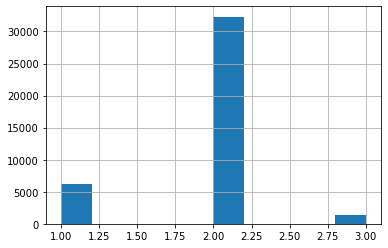

In [2]:
def replace_price(x):
    if x=='$': return 1
    if x=='$$ - $$$': return 2
    if x=='$$$$': return 3
    return x

display(df['Price Range'].value_counts())
df['Price Range'] = df['Price Range'].apply(lambda x: replace_price(x)) #новый признак! (на основе старого) - ординарное значение ценовой категории
df['Price Range'].fillna(df['Price Range'].median(), inplace=True)
df['Price Range'].hist()

In [3]:
print(df.City.value_counts())
print(df.City.nunique())

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64
31


In [4]:
df['Cuisine Style'] = df['Cuisine Style'].fillna("")

In [5]:
styles = df['Cuisine Style'].sum()
styles = styles.replace('\'', '')
styles = styles.replace(', ', ',')
styles = styles.replace('][',',')
styles = styles.replace(']','')
styles = styles.replace('[','')
styles = styles.split(',')
styles = pd.Series(styles)
styles.value_counts()

df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('[\'',''))
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('\']',''))
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.split('\', \''))

#df['num_styles'] = df['Cuisine Style'].apply(lambda x: 1 if len(x)==0 else len(x)) # новый признак! количество кухонь
#df['num_styles'].mean()

df['num_styles'] = df['Cuisine Style'].apply(lambda x: None if len(x)==0 else len(x)) # новый признак! количество кухонь
num_styles_median = df['num_styles'].median()
df['num_styles'] = df['num_styles'].fillna(num_styles_median)

In [6]:
import re
from datetime import datetime

now_d = datetime.now().date()
max_d = datetime.strptime("01/01/1900", "%m/%d/%Y").date()
min_d = now_d
for i in range(0,len(df)):
    groups_rew_dates = re.findall('\d\d\/\d\d\/\d\d\d\d', df.Reviews.iloc[i])
    dates = [datetime.strptime(x, "%m/%d/%Y").date() for x in groups_rew_dates]
    if len(dates)>0 : 
        df.loc[i,'last_date_newness']=abs((now_d-max(dates)).days) # новый признак! новизна последнего отзыва в датасете 
        for j in range(0,len(dates)):
            if dates[j]>max_d:
                max_d = dates[j]
            if dates[j]<min_d:
                min_d = dates[j]
    if len(dates)==2:
        diff = dates[0]-dates[1]
        df.loc[i,'dates_diff']=abs(diff.days) # новый признак! расстояние между датами отзывыв в днях в датасете
    df.loc[i,'num_reviews'] = len(dates) # новый признак! количество отзывов в датасете
        

In [7]:
max_d

datetime.date(2018, 2, 26)

In [8]:
min_d

datetime.date(2004, 4, 21)

In [9]:
df.last_date_newness = df.last_date_newness.fillna(df.last_date_newness.median())
df.last_date_newness.describe()

count    40000.000000
mean      1410.305525
std        337.159940
min       1143.000000
25%       1234.000000
50%       1296.000000
75%       1426.000000
max       6202.000000
Name: last_date_newness, dtype: float64

In [10]:
median_dates_diff = df[(df.num_reviews==2)]['dates_diff'].median()
df.dates_diff = df.dates_diff.fillna(median_dates_diff)
df.dates_diff.describe()

count    40000.000000
mean       121.115900
std        191.165283
min          0.000000
25%         34.000000
50%         67.000000
75%        120.000000
max       3207.000000
Name: dates_diff, dtype: float64

,Ranking,Rating,Price Range,Number of Reviews,num_styles,last_date_newness,dates_diff,num_reviews
Ranking,True,False,False,False,False,False,False,False
Rating,False,True,False,False,False,False,False,False
Price Range,False,False,True,False,False,False,False,False
Number of Reviews,False,False,False,True,False,False,False,False
num_styles,False,False,False,False,True,False,False,False
last_date_newness,False,False,False,False,False,True,False,False
dates_diff,False,False,False,False,False,False,True,False
num_reviews,False,False,False,False,False,False,False,True


0.43283523643356786

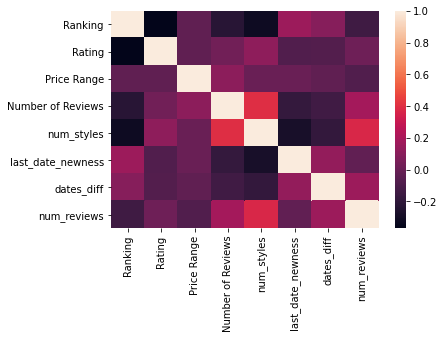

In [11]:
#корреляция числовых признаков без dummies
import numpy as np
import seaborn as sns
C = df.corr()
sns.heatmap(C)
display(abs(C)>0.7) 
np.linalg.det(C) # оценим вырожденность матрицы

In [12]:
#переделываем категориальные пр. в dummies
cities = pd.get_dummies(df.City, 'city')
df = pd.concat([df, cities], axis=1)


df_styles = pd.DataFrame(df['Cuisine Style'])
for i in range(0,len(df_styles)):
    for x in df.loc[i,'Cuisine Style']:
        df_styles.loc[i,'style_'+x] = 1 #1 - если встречается

df_styles = df_styles.drop(['Cuisine Style'], axis = 1)
df_styles = df_styles.fillna(0) #0 - если не встречается
df = pd.concat([df, df_styles], axis=1)



count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

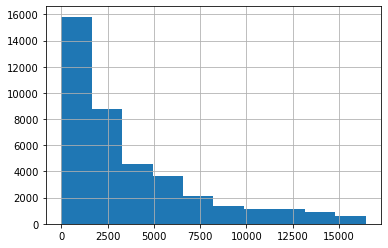

In [13]:
#смотрим распределение 'Ranking'
df.Ranking.hist()
df.Ranking.describe()

count    40000.000000
mean       118.987675
std        286.989212
min          2.000000
25%         10.000000
50%         33.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

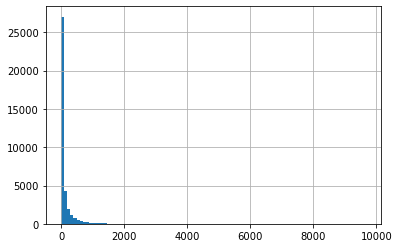

In [14]:
#смотрим распределение 'Number of Reviews'
df['Number of Reviews'].hist( bins=100)
df['Number of Reviews'].fillna(df['Number of Reviews'].median(), inplace=True)
df['Number of Reviews'].describe()


4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

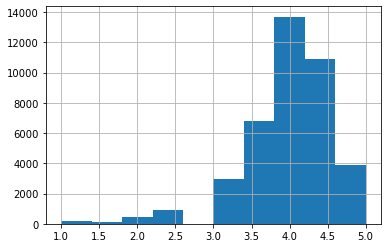

In [15]:
#смотрим распределение таргета 
df.Rating.hist()
display(df.Rating.value_counts())
df.Rating.describe()

In [16]:

X = df.drop(['Rating','Cuisine Style','Reviews','City'], axis = 1)
display(X)
y = df['Rating']
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



,Ranking,Price Range,Number of Reviews,num_styles,last_date_newness,dates_diff,num_reviews,city_Amsterdam,city_Athens,city_Barcelona,...,style_Uzbek,style_Salvadoran,style_Yunnan,style_Native American,style_Canadian,style_Xinjiang,style_Burmese,style_Fujian,style_Welsh,style_Latvian
0,5570.0,2.0,194.0,3,1200.0,41.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1537.0,2.0,10.0,1,1378.0,382.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,353.0,3.0,688.0,7,1192.0,2.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3458.0,2.0,3.0,1,1296.0,67.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,621.0,2.0,84.0,3,1243.0,272.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,2.0,79.0,4,1215.0,34.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39996,6341.0,2.0,542.0,5,1210.0,9.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39997,1652.0,2.0,4.0,2,1623.0,3127.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39998,641.0,2.0,70.0,5,1373.0,23.0,2.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20971350000000002


In [18]:
#идеи: что еще можно сделать
#1) посмотреть матрицу корреляций на предмет "главных компонент" 
#2) поиграться с параметрами модели
#3) поиграться с полиномиальными признаками из наиболее весомых главных компонент
#4) стандартизировать датасет (хотя не факт что для случайного леса это что-то даст)
#5) спарсить отзывы из источника с помощью selenium, прогнать через алгоритм выявления "хороших" и "плохих" масок
#6) определить тональность текста во всех отзывах с помощью ИНС (?) целесообразно ли - не знаю, т к ИНС тоже на чем-то обучать нужно 
#7) проанализировать частоту и новизну спарсенных отзывов, а не тех, что в изначальном датасете